# Предсказание риска ДТП

Вы — специалист по Data Science в каршеринговой компании. Вам поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

## Подключитесь к базе. Загрузите таблицы sql

In [36]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

conn = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'])
engine = create_engine(conn)

## Проведите первичное исследование таблиц

In [37]:
for table in ['collisions', 'vehicles','case_ids','parties']:
    print(pd.read_sql_query(f'''SELECT column_name, data_type
    FROM information_schema.columns
    WHERE table_name = '{table}';''', con=engine), '\n')

                    column_name               data_type
0                   party_count                 integer
1                  intersection                 integer
2                      distance                    real
3                collision_date                    date
4                collision_time  time without time zone
5                 location_type                    text
6              collision_damage                    text
7                       case_id                    text
8        pcf_violation_category                    text
9             type_of_collision                    text
10  motor_vehicle_involved_with                    text
11                 road_surface                    text
12             road_condition_1                    text
13                     lighting                    text
14               control_device                    text
15     primary_collision_factor                    text
16         county_city_location                 

Типы столбцов в таблицах соответствуют заявленным.

In [38]:
for table in ['collisions', 'vehicles','case_ids','parties']:
    print('collisions:',pd.read_sql_query(f'''SELECT COUNT(*) FROM {table}''', con=engine))

collisions:      count
0  1400000
collisions:      count
0  1021234
collisions:      count
0  1400000
collisions:      count
0  2752408


Такое кол-во строк содержат таблицы.

In [39]:
for table in ['collisions', 'vehicles','case_ids','parties']:
    print('collisions:',pd.read_sql_query(f'''SELECT case_id FROM {table}''', con=engine).head(2))

collisions:    case_id
0  4083072
1  4083075
collisions:    case_id
0  5305032
1  3858022
collisions:    case_id
0  0081715
1  0726202
collisions:    case_id
0  3899454
1  3899454


столбец case_id - общий ключ для связи таблиц.

##  Проведите статистический анализ факторов ДТП

### 3.1 Выясните, в какие месяцы происходит наибольшее количество аварий. Проанализируйте весь период наблюдений (таблица collisions).

In [40]:
df = pd.read_sql_query('''
SELECT DISTINCT(EXTRACT('MONTH' FROM collision_date)), COUNT(case_id)
FROM collisions
WHERE EXTRACT('YEAR' FROM collision_date) = 2012
GROUP BY DISTINCT(EXTRACT('MONTH' FROM collision_date))
''', con=engine)
df.head(30)

,extract,count
0,1.0,32020
1,2.0,30377
2,3.0,32498
3,4.0,29143
4,5.0,25168
5,6.0,3062
6,7.0,390
7,8.0,622
8,9.0,510
9,10.0,304


Видно, что почему-то резко падает кол-во аварий во 2-й половине 2012 года. Поэтому будем брать для анализа всё, что до 2012 года.

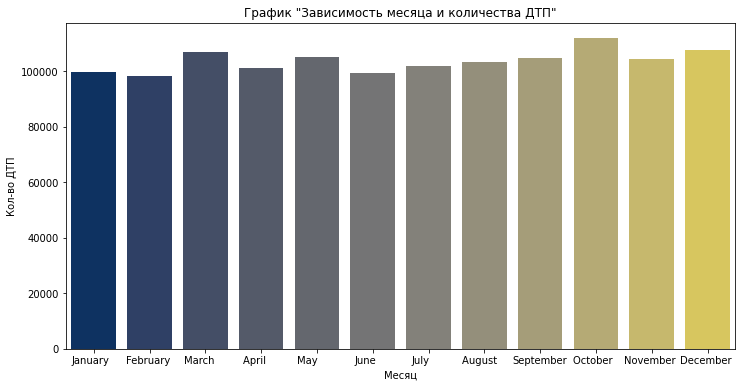

In [41]:
hist = pd.read_sql_query('''
SELECT COUNT(DISTINCT(case_id)), TO_CHAR(collision_date, 'Month') as month
FROM collisions
WHERE EXTRACT('YEAR' FROM collision_date) BETWEEN 2008.0 AND 2011.0
GROUP BY TO_CHAR(collision_date, 'Month'), EXTRACT(MONTH FROM collision_date)
ORDER BY EXTRACT(MONTH FROM collision_date)
''', con=engine)
plt.figure(figsize=(12, 6))
sns.barplot(data=hist, x='month', y='count', color='blue', palette='cividis')
plt.xlabel('Месяц')
plt.title('График "Зависимость месяца и количества ДТП"')
plt.ylabel('Кол-во ДТП');

**Итог: Самое большое кол-во аварий происходит в осенне-весенние месяцы.**

### 3 Скоро состоится первое совещание вашей рабочей группы. Чтобы обсуждение было конструктивным, каждый сотрудник должен понимать данные. Для этого вы должны создать подходящие аналитические задачи и поручить их решение коллегам.

### 3.2.1 Создайте не менее шести задач для коллег. 

1. Нужно провести анализ времени проишествия. Важно знать - в какое время суток зачастую происходят ДТП. Освещение, усталость влияют на дорожное движение, а также заказчику необходимо знать, нужно ли оборудовать автомобиль какими-то датчиками или камерой с хорошей видимостью ночью.
2. Также необходимо провести анализ погоды. Гололед, осадки, видимость влияют на дорожное движение. Если же погода зачастую дождливая или снежная во время ДТП, то, если автомобиль необходимо оборудовать датчиками, то они должны быть защищены от осадков.
3. Провести анализ типа дороги. Важно знать, где зачастую происходят ДТП.
4. Необходимо проанализировать категорию нарушения. Если ДТП часто происходят из-за алкоголя или наркотиков, необходимо поставить датчики, которые проверяют человека на трезвость, и только потом разрешают двигаться в путь.
5. Было бы неплохо проанализировать "Дополнительные участники ДТП". Если же часто ДТП происходят с участием неподвижных обьектов, то машину необходимо оборудовать парктрониками.
6. Дорожное состояние может влиять на движение. 
7. Необходимо проверить описание участников проишествия. А точнее их состояние на момент ДТП. Лекарства, сонливость, ухудшение состояния повышают риски ДТП. 
8. Отвлечение на телефон также повышает риск ДТП. В случае связи автомобиль необходимо оборудовать техникой, позволяющей разговаривать на громкой связи.
9. Проанализировать возраст машины и количество ДТП. Старые машины менее оснащены новыми мерами безопасности, и более легки на поломки.
10. Проанализировать тип кузова автомобиля и ДТП. Длинные, большие машины более сложны в управлении.

### 3.2.2 Пропишите порядок решения для двух задач из списка. Реализуйте его. Обязательное условие — решение этих задач должно включать связь не менее 2-х таблиц. Пример прописанного порядка:
* Создайте sql-запрос;
* Постройте график;
* Сделайте вывод.

Реализуем пункты: 
* 9. Проанализировать возраст машины и количество ДТП. Старые машины менее оснащены новыми мерами безопасности, и более легки на поломки.
* 10. Проанализировать тип кузова автомобиля и ДТП. Длинные, большие машины более сложны в управлении.

Порядок решения пункта 9:
1. Создать sql-запрос, где будет таблица Parties - виновник Машина.
2. Создать sql-запрос, где будет таблица Vehicles - год автомобиля.
3. Обьединить запросы.
4. Построить гистограммму, которая покажет - зависим ли год авто и ДТП.
5. Сделать вывод.

Порядок решения пункта 10:
1. Создать sql-запрос, где будет таблица Parties - виновник Машина.
2. Создать sql-запрос, где будет таблица Vehicles - кузов автомобиля.
3. Обьединить запросы.
4. Построить гистограммму, которая покажет - зависим ли год авто и ДТП.
5. Сделать вывод.

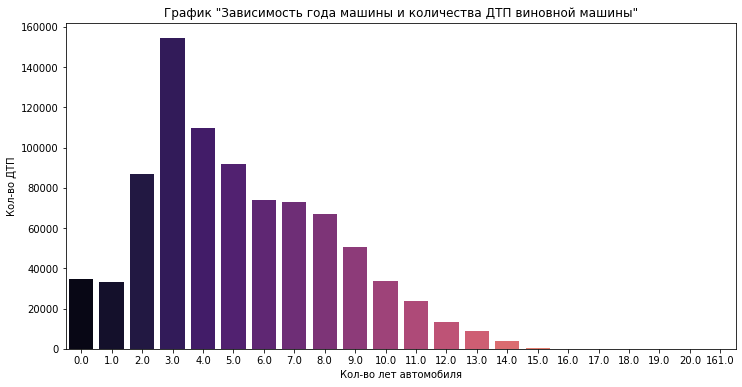

In [42]:
df = pd.read_sql_query('''
WITH parties AS (
    SELECT case_id
    FROM parties
    WHERE PARTY_TYPE = 'car' AND AT_FAULT = 1
),
vehicles AS (
    SELECT case_id, vehicle_age
    FROM vehicles v
            )
SELECT COUNT(DISTINCT(p.case_id)), vehicle_age
FROM parties p
INNER JOIN vehicles v ON p.case_id = v.case_id
GROUP BY vehicle_age;
''', con=engine)
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='vehicle_age', y='count', color='red', palette='magma')
plt.xlabel('Кол-во лет автомобиля')
plt.title('График "Зависимость года машины и количества ДТП виновной машины"')
plt.ylabel('Кол-во ДТП');

**Итог: график показал, что есть зависимость между годом авто и кол-вом ДТП. Но так как нет данных об общем кол-ве машин у компании, то график может быть не репрезентативным. Такое может быть в случае, если 3 года назад комания закупила 3 тысячи машин, а 6 лет назад в 2 раза меньше.**

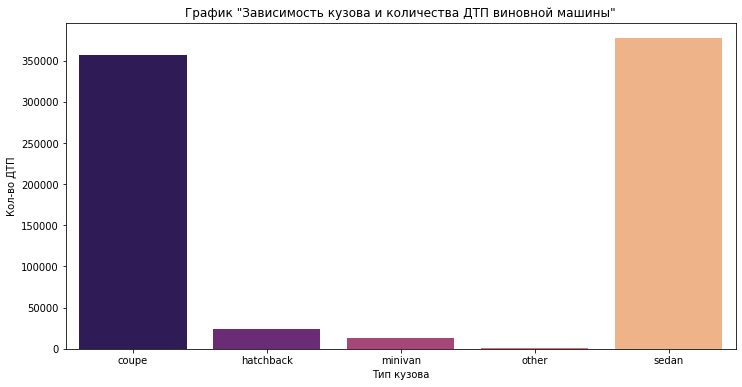

In [43]:
df = pd.read_sql_query('''
WITH parties AS (
    SELECT case_id
    FROM parties
    WHERE PARTY_TYPE = 'car' AND AT_FAULT = 1
),
vehicles AS (
    SELECT case_id, vehicle_type
    FROM vehicles v
            )
SELECT COUNT(DISTINCT(p.case_id)), vehicle_type
FROM parties p
INNER JOIN vehicles v ON p.case_id = v.case_id
GROUP BY vehicle_type;
''', con=engine)
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='vehicle_type', y='count', color='red', palette='magma')
plt.xlabel('Тип кузова')
plt.title('График "Зависимость кузова и количества ДТП виновной машины"')
plt.ylabel('Кол-во ДТП');

**Итог: некрупные и большие машины попадают в ДТП примерно одинаково. У нас нет данных о количестве авто у компании, чтобы подсчитать соотношение_общего_кол-ва_машин/виновные_в_дтп, но имеющиеся данные показывают, что зависимости нет.**

## Создайте модель для оценки водительского риска

### Предобработка данных

In [44]:
df = pd.read_sql_query('''
WITH parties AS (
    SELECT case_id, at_fault, party_sobriety, cellphone_in_use
    FROM parties
    WHERE PARTY_TYPE = 'car'
),
collisions AS (
SELECT *
FROM collisions
WHERE (EXTRACT('YEAR' FROM collision_date ) = 2012) AND (collision_damage <> 'scratch')
),
vehicles AS (
SELECT case_id,vehicle_age,vehicle_type
FROM vehicles
)
SELECT *
FROM parties p
INNER JOIN collisions c ON p.case_id = c.case_id
INNER JOIN vehicles v ON p.case_id = v.case_id
''', con=engine)
df = df.reset_index()

На этом датасете будет обучаться модель.

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   index                        118411 non-null  int64  
 1   case_id                      118411 non-null  object 
 2   at_fault                     118411 non-null  int64  
 3   party_sobriety               116682 non-null  object 
 4   cellphone_in_use             107507 non-null  float64
 5   case_id                      118411 non-null  object 
 6   county_city_location         118411 non-null  object 
 7   county_location              118411 non-null  object 
 8   distance                     118411 non-null  float64
 9   direction                    89466 non-null   object 
 10  intersection                 118043 non-null  float64
 11  weather_1                    118022 non-null  object 
 12  location_type                55137 non-null   object 
 13 

In [46]:
df.duplicated().sum()

0

In [47]:
columns = ['intersection','weather_1','road_surface','lighting','county_city_location',
           'distance','road_condition_1',
           'at_fault', 'vehicle_age', 'vehicle_type', 'party_sobriety', 'cellphone_in_use']
data = df[columns]

In [48]:
data = data.rename({'weather_1':'weather', 'road_condition_1':'road_condition'}, axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   intersection          118043 non-null  float64
 1   weather               118022 non-null  object 
 2   road_surface          117645 non-null  object 
 3   lighting              118080 non-null  object 
 4   county_city_location  118411 non-null  object 
 5   distance              118411 non-null  float64
 6   road_condition        117843 non-null  object 
 7   at_fault              118411 non-null  int64  
 8   vehicle_age           115046 non-null  float64
 9   vehicle_type          118411 non-null  object 
 10  party_sobriety        116682 non-null  object 
 11  cellphone_in_use      107507 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 10.8+ MB


* intersection - может влиять на риск ДТП, т.к. перекрестки - участки дороги с большим потоком машин.
* weather - погода влияет на риск ДТП. Плохая видимость, холодный асфальт, гололед влияют на управление машиной.
* road_surface - состояние дороги влияет на управление машиной.
* lighting - освещенность влияет на обзор дороги, а следовательно плохая освещенность увеличивает риск ДТП.
* county_city_location - если в каких то районах плохое покрытие, это влияет на риск ДТП.
* party_count - количество участников может влиять на водителя, отвлечение от дороги увеличивает риск ДТП.
* road_condition - материал, из которого сделана дорога также влияет на риск ДТП. Затопленные, узкие участки увеличивают риск ДТП.
* vehicle_age - с возврастом машины становятся хуже, влияет на риск ДТП.
* vehicle_type - влияет на маневренность машины, а следовательно, может увеличить риск ДТП.

**Остальные признаки либо имели большое кол-во выбросов, либо они могли не повлиять на вероятность ДТП, поэтому они не были включены в список.**

In [49]:
#дисбаланс классов
data['at_fault'].value_counts()

0    62795
1    55616
Name: at_fault, dtype: int64

In [50]:
data.loc[data['lighting'] == 'dark with street lights not functioning', 'lighting'] = 'dark with no street lights'
data.loc[data['weather'].isin(['wind','snowing','fog']),'weather'] = 'other'
data.loc[data['road_surface'].isin(['showy','slippery']),'road_surface'] = 'other'
data.loc[data['party_sobriety'].isin(['had been drinking, impairment unknown','not applicable',
                                     'had been drinking, not under influence']),'party_sobriety'] = 'other'
#for col in data.columns:
#    print(data[col].value_counts())
data = data.dropna()
data = data.astype({'county_city_location':'int64'})

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102239 entries, 0 to 118410
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   intersection          102239 non-null  float64
 1   weather               102239 non-null  object 
 2   road_surface          102239 non-null  object 
 3   lighting              102239 non-null  object 
 4   county_city_location  102239 non-null  int64  
 5   distance              102239 non-null  float64
 6   road_condition        102239 non-null  object 
 7   at_fault              102239 non-null  int64  
 8   vehicle_age           102239 non-null  float64
 9   vehicle_type          102239 non-null  object 
 10  party_sobriety        102239 non-null  object 
 11  cellphone_in_use      102239 non-null  float64
dtypes: float64(4), int64(2), object(6)
memory usage: 10.1+ MB


Теперь столбцы принимают адекватные категориальные значения.

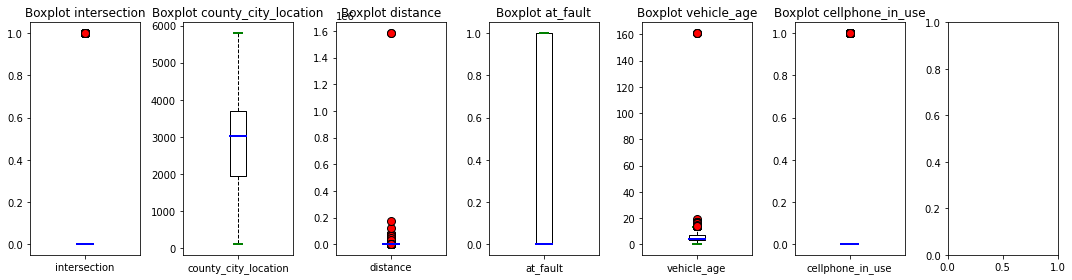

In [52]:
boxprops = dict(linewidth=1, color='black')
whiskerprops = dict(linewidth=1, color='black', linestyle='dashed')
flierprops = dict(marker='o', markersize=8, markerfacecolor='red', markeredgecolor='black')
medianprops = dict(linewidth=2, color='blue')
capprops = dict(linewidth=2, color='green')
# Создаем subplots
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(15, 4))
i = 0
for col in data.select_dtypes(include='number').columns:
    data[col].plot(kind='box', ax=axes[i], boxprops=boxprops, whiskerprops=whiskerprops,
                     flierprops=flierprops, medianprops=medianprops, capprops=capprops)
    axes[i].set_title(f'Boxplot {col}')
    i += 1
# Убираем лишние пробелы между графиками
plt.tight_layout()
plt.show()

In [53]:
data.describe()

,intersection,county_city_location,distance,at_fault,vehicle_age,cellphone_in_use
count,102239.000000,102239.000000,1.022390e+05,102239.000000,102239.000000,102239.000000
mean,0.214898,2836.946488,8.011964e+02,0.461243,4.910015,0.021205
std,0.410754,1268.798757,7.407355e+03,0.498498,3.285231,0.144069
min,0.000000,100.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,1942.000000,1.000000e+01,0.000000,3.000000,0.000000
50%,0.000000,3009.000000,1.500000e+02,0.000000,4.000000,0.000000
75%,0.000000,3700.000000,6.000000e+02,1.000000,7.000000,0.000000
max,1.000000,5802.000000,1.584000e+06,1.000000,161.000000,1.000000


(102239, 12) before


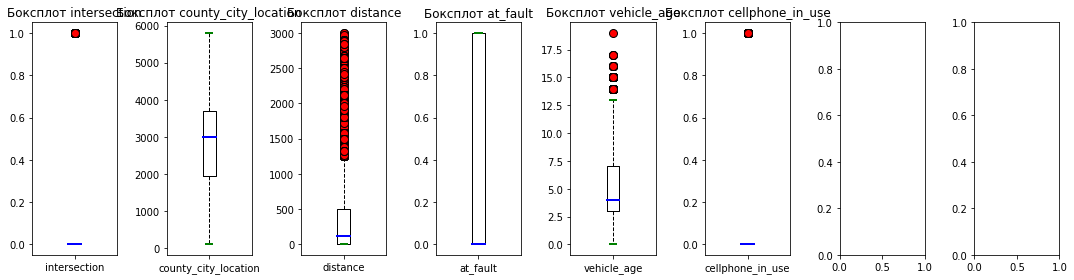

(97007, 12) after


In [54]:
print(data.shape, 'before')
data = data[data['vehicle_age'] < 20]
data = data[data['distance'] < 3000]
boxprops = dict(linewidth=1, color='black')
whiskerprops = dict(linewidth=1, color='black', linestyle='dashed')
flierprops = dict(marker='o', markersize=8, markerfacecolor='red', markeredgecolor='black')
medianprops = dict(linewidth=2, color='blue')
capprops = dict(linewidth=2, color='green')
# Создаем subplots
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(15, 4))
i = 0
for col in data.select_dtypes(include='number').columns:
    data[col].plot(kind='box', ax=axes[i], boxprops=boxprops, whiskerprops=whiskerprops,
                     flierprops=flierprops, medianprops=medianprops, capprops=capprops)
    axes[i].set_title(f'Боксплот {col}')
    i += 1
# Убираем лишние пробелы между графиками
plt.tight_layout()
plt.show()
print(data.shape, 'after')

In [55]:
print(data.duplicated().sum()) #слишком много, удаляем
data = data.drop_duplicates()

25447


In [56]:
data_train, data_test = train_test_split(data,test_size = 0.3, random_state = 1)
data_test, data_valid = train_test_split(data,test_size = 0.5, random_state = 1)
y_train = data_train['at_fault']
y_test = data_test['at_fault']
y_valid = data_valid['at_fault']
x_train = data_train.drop(['at_fault'], axis = 1)
x_test = data_test.drop(['at_fault'], axis = 1)
x_valid = data_valid.drop(['at_fault'], axis = 1)

### Обучение моделей

**RandomForest**

In [57]:
from sklearn.preprocessing import OneHotEncoder
x_train_ohe = x_train.copy()
x_test_ohe = x_test.copy()
ohe_features_ridge = x_train_ohe.select_dtypes(include='object').columns.to_list()
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
encoder_ohe.fit(x_train_ohe[ohe_features_ridge])

x_train_ohe[encoder_ohe.get_feature_names()] = encoder_ohe.transform(x_train_ohe[ohe_features_ridge])
x_test_ohe[encoder_ohe.get_feature_names()] = encoder_ohe.transform(x_test_ohe[ohe_features_ridge])

x_train_ohe = x_train_ohe.drop(ohe_features_ridge, axis=1)
x_test_ohe = x_test_ohe.drop(ohe_features_ridge, axis=1)

best_acc = 0
best_f1 = 0
best_est = 0
best_depth = 0
for est in [10, 20,30,40,50, 60, 70, 80, 90, 100, 110]:
    for depth in [5, 7, 9, 11, 14 , 13, 15, 17, 19]:
        model = RandomForestClassifier(n_estimators = est,max_depth = depth, criterion = 'gini',random_state = 12345)
        model.fit(x_train_ohe, y_train)
        predictions = model.predict(x_test_ohe)
        recall = recall_score(y_test, predictions)
        f1 = f1_score(y_test,predictions)
        if f1 > best_f1:
            best_recall_one = recall
            best_f1_one = f1
            best_model_randomforest = model
            best_est = est
            best_depth = depth
            pred_best = predictions
print('Лучший recall:', best_recall_one)
print('Лучший f1:', best_f1_one)
print('Лучший depth:', best_depth)
print('Лучший est:', best_est)
print('Матрица ошибок:', confusion_matrix(y_test, pred_best), sep = '\n')

Лучший recall: 0.6018606117943867
Лучший f1: 0.6663950883114615
Лучший depth: 19
Лучший est: 110
Матрица ошибок:
[[12864  3890]
 [ 7575 11451]]


**LogisticRegression**

In [58]:
best_acc = 0
best_f1 = 0
best_est = 0
best_depth = 0
for sol in ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]:
    for pen in ['l1','l2']:
        model_regression = LogisticRegression(solver = sol,random_state = 12345, penalty = pen)
        model.fit(x_train_ohe, y_train)
        predictions = model.predict(x_test_ohe)
        recall = recall_score(predictions, y_test)
        f1 = f1_score(predictions, y_test)
        if f1 > best_f1:
            best_recall_two = recall
            best_f1_two = f1
            best_model_regression = model_regression
            best_sol = sol
            best_pen = pen
            pred_best = predictions
print('Лучший recall:', best_recall_two)
print('Лучший f1:', best_f1_two)
print('Лучший pen:', best_pen)
print('Лучший sol:', best_sol)
print('Матрица ошибок:', confusion_matrix(y_test, pred_best), sep = '\n')

Лучший recall: 0.7464311322599569
Лучший f1: 0.6663950883114615
Лучший pen: l2
Лучший sol: saga
Матрица ошибок:
[[12864  3890]
 [ 7575 11451]]


f1 остался таким же, а вот recall уже увеличился значительно.

**CatBoost**

In [59]:
x_train.loc[x_train['cellphone_in_use'] == 1.0, 'cellphone_in_use'] = 'yes'
x_train.loc[x_train['cellphone_in_use'] == 0.0, 'cellphone_in_use'] = 'no'
x_test.loc[x_test['cellphone_in_use'] == 1.0, 'cellphone_in_use'] = 'yes'
x_test.loc[x_test['cellphone_in_use'] == 0.0, 'cellphone_in_use'] = 'no'
x_valid.loc[x_valid['cellphone_in_use'] == 1.0, 'cellphone_in_use'] = 'yes'
x_valid.loc[x_valid['cellphone_in_use'] == 0.0, 'cellphone_in_use'] = 'no'

x_train.loc[x_train['intersection'] == 1.0, 'intersection'] = 'yes'
x_train.loc[x_train['intersection'] == 0.0, 'intersection'] = 'no'
x_test.loc[x_test['intersection'] == 1.0, 'intersection'] = 'yes'
x_test.loc[x_test['intersection'] == 0.0, 'intersection'] = 'no'
x_valid.loc[x_valid['intersection'] == 1.0, 'intersection'] = 'yes'
x_valid.loc[x_valid['intersection'] == 0.0, 'intersection'] = 'no'

x_train = x_train.astype({'county_city_location':'object'})
x_test = x_test.astype({'county_city_location':'object'})
x_valid = x_valid.astype({'county_city_location':'object'})



In [60]:
objects = x_train.select_dtypes(include=['object', 'category']).columns.to_list()
for rate in [0.7,0.8]:
    model_cb = CatBoostClassifier(cat_features = objects,
                              eval_metric = 'TotalF1',
                              verbose = 100,
                              random_seed = 42,
                             learning_rate = rate)
    model_cb.fit(x_train, 
             y_train,
             eval_set = (x_test, y_test))
    predictions = model_cb.predict(x_test)
    f1_three = f1_score(predictions, y_test)
    recall_three = recall_score(predictions, y_test)
    print(recall_three)

0:	learn: 0.4924998	test: 0.4908786	best: 0.4908786 (0)	total: 179ms	remaining: 2m 58s
100:	learn: 0.6375561	test: 0.5340505	best: 0.5769436 (3)	total: 9.39s	remaining: 1m 23s
200:	learn: 0.6643837	test: 0.5341426	best: 0.5769436 (3)	total: 19.1s	remaining: 1m 15s
300:	learn: 0.6866733	test: 0.5299226	best: 0.5769436 (3)	total: 29.1s	remaining: 1m 7s
400:	learn: 0.7026872	test: 0.5292338	best: 0.5769436 (3)	total: 39.3s	remaining: 58.6s
500:	learn: 0.7212606	test: 0.5236137	best: 0.5769436 (3)	total: 49.6s	remaining: 49.4s
600:	learn: 0.7351174	test: 0.5249348	best: 0.5769436 (3)	total: 59.4s	remaining: 39.4s
700:	learn: 0.7512597	test: 0.5273324	best: 0.5769436 (3)	total: 1m 9s	remaining: 29.9s
800:	learn: 0.7653886	test: 0.5206098	best: 0.5769436 (3)	total: 1m 20s	remaining: 20s
900:	learn: 0.7804242	test: 0.5204955	best: 0.5769436 (3)	total: 1m 30s	remaining: 9.99s
999:	learn: 0.7939659	test: 0.5205345	best: 0.5769436 (3)	total: 1m 40s	remaining: 0us

bestTest = 0.5769436276
bestIte

Модель CatBoost показывает результаты по f1 и recall лучше, чем предыдущие модели.

**Обоснование выбора метрики:** мой выбор склонялся к метрике f1, так как она - что то среднее между precision и recall. Так как в нашем случае лучше определить лишние параметры в false positivte, чем false negative, то можно было бы сколняться к метрике recall, но я всё же выбрал f1 в качестве основной метрики, но и не забыл про recall, он играет роль вспомогательной метрики. Например, если бы f1 была одинаковая у двух моделей, а recall сильно разнился, то я бы выбрал лучшую по recall.

In [61]:
df = pd.DataFrame()
df['models'] = ['RF', 'DT', 'CB']
df['recall'] = [best_recall_one, best_recall_two, recall_three]
df['f1'] = [best_f1_one, best_f1_two, model_cb.best_score_['validation']['TotalF1']]
df.head()

,models,recall,f1
0,RF,0.601861,0.666395
1,DT,0.746431,0.666395
2,CB,0.642868,0.569457


**Итог: в таблице видно, что у модели CatBoost все показатели сильно превосходят показатели других моделей.**

## Тестирование лучшей модели

In [62]:
objects = x_train.select_dtypes(include=['object', 'category']).columns.to_list()

model_cb = CatBoostClassifier(cat_features = objects,
                              eval_metric = 'TotalF1',
                              verbose = 100,
                              random_seed = 42,
                             learning_rate = 0.8)
model_cb.fit(x_train, 
             y_train,
             eval_set = (x_test, y_test))
predictions = model_cb.predict(x_valid)
f1_three = f1_score(predictions, y_valid)
recall_three = recall_score(predictions, y_valid)
print(f1_three, recall_three)

0:	learn: 0.4924998	test: 0.4908786	best: 0.4908786 (0)	total: 116ms	remaining: 1m 55s
100:	learn: 0.6391736	test: 0.5248143	best: 0.5694573 (1)	total: 10s	remaining: 1m 29s
200:	learn: 0.6654412	test: 0.5264950	best: 0.5694573 (1)	total: 19.3s	remaining: 1m 16s
300:	learn: 0.6910819	test: 0.5200517	best: 0.5694573 (1)	total: 29.1s	remaining: 1m 7s
400:	learn: 0.7100955	test: 0.5231196	best: 0.5694573 (1)	total: 39.1s	remaining: 58.4s
500:	learn: 0.7293588	test: 0.5235736	best: 0.5694573 (1)	total: 49.4s	remaining: 49.2s
600:	learn: 0.7451105	test: 0.5242008	best: 0.5694573 (1)	total: 59.8s	remaining: 39.7s
700:	learn: 0.7602140	test: 0.5259952	best: 0.5694573 (1)	total: 1m 10s	remaining: 29.9s
800:	learn: 0.7742581	test: 0.5231485	best: 0.5694573 (1)	total: 1m 20s	remaining: 20.1s
900:	learn: 0.7876647	test: 0.5227290	best: 0.5694573 (1)	total: 1m 31s	remaining: 10s
999:	learn: 0.8008692	test: 0.5214085	best: 0.5694573 (1)	total: 1m 41s	remaining: 0us

bestTest = 0.5694573097
bestIter

## Проведите анализ важности факторов ДТП

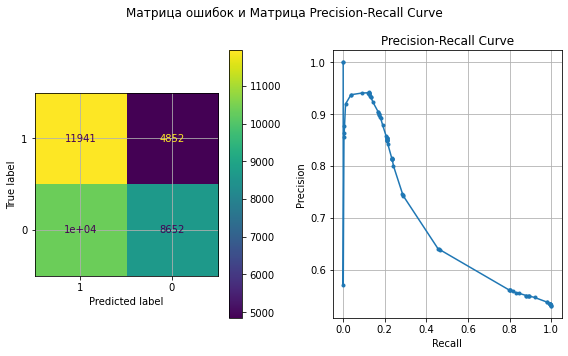

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
y_pred = model_cb.predict(x_valid)
y_pred_pr = model_cb.predict_proba(x_valid)
conf_matrix = confusion_matrix(y_valid, y_pred)
conf_matrix
precision, recall, _ = precision_recall_curve(y_valid, y_pred_pr[:, 1])

disp = ConfusionMatrixDisplay(
    conf_matrix,
    display_labels=[1, 0]
)
fig, ax = plt.subplots(1,2, figsize=(8, 5))
disp.plot(ax=ax[0])
fig.suptitle('Матрица ошибок и Матрица Precision-Recall Curve')
ax[0].grid()
ax[1].plot(recall, precision, marker='.')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve')
ax[1].grid()
plt.tight_layout()
plt.show()

Очень неплохой результат, модель в очень редких случаях делает ошибки false positive.

In [24]:
model_cb.get_feature_importance(prettified = True).head(10)

,Feature Id,Importances
0,county_city_location,28.171274
1,distance,16.481986
2,lighting,11.094466
3,vehicle_age,10.261872
4,vehicle_type,10.210692
5,weather,7.323563
6,party_sobriety,5.483783
7,road_surface,4.982017
8,road_condition,4.472867
9,cellphone_in_use,0.802730


Самые важные признаки - тип района, дистанция до главной дороги, освещение.

Посмотрим на зависимость кол-ва участников и переменной.

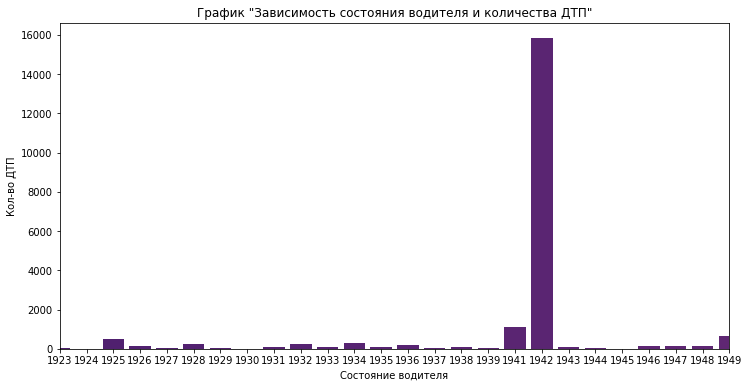

In [25]:
df = pd.read_sql_query('''
WITH parties AS (
    SELECT case_id, at_fault, party_sobriety, cellphone_in_use
    FROM parties
    WHERE PARTY_TYPE = 'car'
),
collisions AS (
SELECT *
FROM collisions
WHERE (EXTRACT('YEAR' FROM collision_date ) = 2012) AND (collision_damage <> 'scratch')
),
vehicles AS (
SELECT case_id,vehicle_age,vehicle_type
FROM vehicles
)
SELECT DISTINCT(county_city_location), COUNT(at_fault)
FROM parties p
INNER JOIN collisions c ON p.case_id = c.case_id
INNER JOIN vehicles v ON p.case_id = v.case_id
GROUP BY DISTINCT(county_city_location)
''', con=engine)
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='county_city_location', y='count', color='red', palette='magma')
plt.xlabel('Состояние водителя')
plt.xlim(125, 150)
plt.title('График "Зависимость состояния водителя и количества ДТП"')
plt.ylabel('Кол-во ДТП');

**Итог:** Я взял определенный промежуток, чтобы было наглядно понятно, что существуют определенные районы, где аварии происходят очень часто. Возможно, в них есть проблемы с регулированием перекрестков, нанесением разметки, качеством дорожного полотна. Такие районы лучше объезжать, чтобы уменьшить риски.

**Предложение:** 
* Внедренная модель построения маршрута должна будет знать все "опасные" районы, в которых часто происходят ДТП. 
* Также признак трезвости имеет вес у обученной модели. Понятно, что человек в состоянии опьянения с огромной вероятностью попадет в ДТП. В данном случае машину необходимо оборудовать алкотестером, который не разрешит управление, пока человек не дунет в трубку и результат не покажет, что человек трезв.
* Освещение и год автомобиля тоже значимы, можно поставить доп.освещение, обновить авто и тд.

## Выводы

Создание адекватной системы оценки риска возможно, если добыть достаточное кол-во информации. В нашем случае необходимо:
* Во-первых, оборудовать авто алкотестером. 
* Во-вторых, было бы неплохо более точно определить места, в которых ДТП происходят очень часто. Ведь у нас есть информация только по районам, и модель будет указывать объехать весь район (которые зачастую немаленькие), чтобы, возможно, обойти какой-то опасный поворот/перекресток. Это еще и даст прирост на показателе качества модели.

Я смог построить вполне неплохую модель, но считаю, что нужно дополнить её данными, чтобы можно было использовать на практике.